# Problem Selection and Definition

## Problem Selection
1. Unsupervised 10-class classification of song lyrics.
2. Label prediction of song lyrics.

## Problem Definition
The dataset contains thousands of unlabeled song lyrics.
1. Each song will be labeled based on the content of its lyrics.
2. Top words of its lyrics will be selected as features for the models.
3. Models will be trained to predict the label of a song from its top 10 words.

## Dataset

The dataset for this project will be the **380,000+ lyrics from MetroLyrics**, which can be found at https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data

# Data Exploration and Preparation

## Initialize libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import pickle
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
%matplotlib inline

# Normalization
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel, CoherenceModel
from gensim.models import word2vec

# Lemmatization
import spacy

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Helpers
from helpers.saved_data import SavedModel, saved_function
from helpers import RGSR

#External
from external.feature_labs import plot_confusion_matrix

In [2]:
data = pd.read_csv('data/lyrics.csv')
data.rename(columns={'song':'title'}, inplace=True)

## Are all the features relevant?

In [3]:
data.dtypes

index      int64
title     object
year       int64
artist    object
genre     object
lyrics    object
dtype: object

We are not interested in the index feature.

In [4]:
data.drop(columns='index', inplace=True)

## How big is the dataset?

In [5]:
data.shape

(362237, 5)

In [6]:
data.sample(5)

,title,year,artist,genre,lyrics
94794,cryogenic-husk,2007,agoraphobic-nosebleed,Metal,Thaw the Quaaludes from cryogenic husk\nLift t...
361135,don-t-hate-me,2006,112,Hip-Hop,Don't be mad if yo' girl wants to leave with m...
208651,live-freestyle-95,2006,big-daddy-kane,Hip-Hop,[kane]\twhere's 2pac and biggie smalls? ?\n*cr...
120870,five-more-hours,2015,chris-brown,Hip-Hop,What you wanna do baby?\nWhere you wanna go?\n...
293249,cold,2014,french-for-rabbits,Indie,NaN


The dataset has 362,237 songs and we are interested in 5 features:
artist, song, genre, year and lyrics.

## Is there any data missing?

In [7]:
pd.DataFrame(
    [[str(column), np.where(data[column].isnull())[0].size]
    for column in data.columns],
    columns=['Column','Missing'])

,Column,Missing
0,title,2
1,year,0
2,artist,0
3,genre,0
4,lyrics,95680


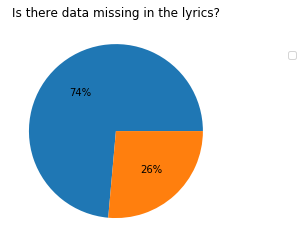

In [8]:
plot_data = pd.Series(np.where(data['lyrics'].isnull(), 'Yes', 'No')).value_counts()
plt.title('Is there data missing in the lyrics?')
plt.legend(labels=['Not missing', 'Missing'],
           loc = 'center right',
           bbox_to_anchor=(1.35 ,0.85))
_=plt.pie(plot_data, autopct='%1.0f%%')


* There are 95,680 songs with missing lyrics in the data.
* There are only 2 titles missing.

## Can we recover the missing data?

### Missing songs
There are only 2 songs missing, these can be looked up manually using external sources.

In [9]:
data.loc[data['title'].isnull()]

,title,year,artist,genre,lyrics
193957,NaN,2009,booker-t-and-the-mg-s,Jazz,"All right people, the rest of the hard working..."
325992,NaN,2009,booker-t,Jazz,NaN


In [10]:
data.at[193957, 'title'] = 'green-onions' # Google

In [11]:
data.drop([325992], inplace=True)
data.reset_index(drop=True)

,title,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...
362231,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362232,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362233,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362234,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


Of the 2 songs with missing titledata, only one of them had enough information to recover the missing value, the other row was dropped.

### Missing lyrics

In [12]:
import tswift # Python API for getting lyrics from MetroLyrics
import time, random

@np.vectorize
def fetch_lyrics(artist, songs):
    '''Fetches song lyrics from Metrolyrics'''
    time.sleep(0.1 + random.random() * 0.1)
    fetcher = tswift.Artist(artist.replace('-',' '))
    fetcher_songs = fetcher.songs
    available_songs = (song.title.lower() for song in fetcher_songs)
    if song in available_songs:
        print(f'Found: {artist} {song}')
        fetcher_song = fetcher_songs[avail_songs.index(song)]
        lyrics = fetcher_song.format().split('\n', 4)[-1]
        return lyrics
    return pd.np.nan

missing_lyrics = data.loc[data['lyrics'].isnull()]
print(f"There are {pd.unique(missing_lyrics['artist']).size:,} different artists with missing lyrics.")
#missing_lyrics['lyrics'] = fetch_lyrics(missing_lyrics['artist'], missing_lyrics['song'])
del(missing_lyrics)

There are 8,730 different artists with missing lyrics.


In [13]:
data.dropna(inplace=True)

In [14]:
data.shape

(266557, 5)

Even though fetching the lyrics would be possible if they existed in the MetroLyrics dataset, we decided against it to avoid flooding their servers with requests. Instead, the songs with missing lyrics were dropped. We are now left with 266,557 rows in the dataset.

## Are there outliers in Year?

In [15]:
data['year'].describe()

count    266557.000000
mean       2007.654914
std          10.115230
min          67.000000
25%        2006.000000
50%        2007.000000
75%        2010.000000
max        2016.000000
Name: year, dtype: float64

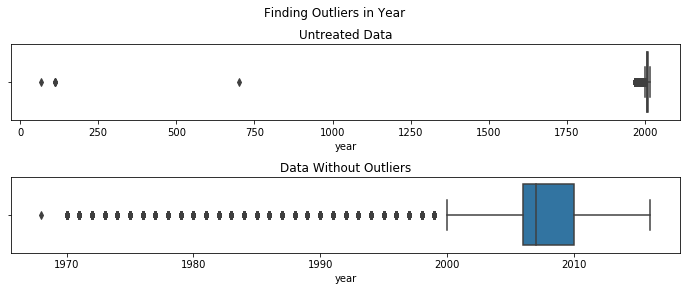

In [16]:
fig, ax = plt.subplots(2,1, figsize=(12, 4))
fig.subplots_adjust(hspace=.75, top=.85)
fig.suptitle('Finding Outliers in Year')

plt.sca(ax[0])
plt.title('Untreated Data')
_=sns.boxplot(x=data['year'])

plt.sca(ax[1])
plt.title('Data Without Outliers')
_=sns.boxplot(x=data.drop(data[data['year']<1900].index)['year'])

With the outliers removed, it's easier to see that most of the songs are from 2006 - 2010.

In [17]:
data[data['year']<1900]

,title,year,artist,genre,lyrics
27657,star,702,clipse,Hip-Hop,You're my star\nIt's such a wonder how you shi...
69708,anywhere-remix,112,dru-hill,Hip-Hop,"Here we are all alone\nYou and me, privacy\nAn..."
147914,it-s-over-now-remix,112,g-dep,Hip-Hop,What is this?\nNumbers in your pocket\nI remem...
238541,come-see-me-remix,112,black-rob,Hip-Hop,"Baby, you can come see me 'cause I need you he..."
315540,let-s-lurk,67,giggs,Hip-Hop,Verse 1:\nStill pulling up on smoke\nSkeng in ...
335205,i-can-t-believe,112,faith-evans,Pop,[Chorus]\nI can't believe that love has gone a...


There are only 6 outliers, so they can be looked up manually using external sources.

In [18]:
data.at[27657, 'year'] = 2003 # discogs.com
data.at[69708, 'year'] = 1999 # discogs.com
data.at[147914, 'year'] = 2001 # discogs.com
data.at[238541, 'year'] = 1996 # discogs.com
data.at[315540, 'year'] = 2016 # Google
data.at[335205, 'year'] = 1996 # Google

## Binning Year into time periods

In [19]:
data['year'].describe()

count    266557.000000
mean       2007.695408
std           5.279087
min        1968.000000
25%        2006.000000
50%        2007.000000
75%        2010.000000
max        2016.000000
Name: year, dtype: float64

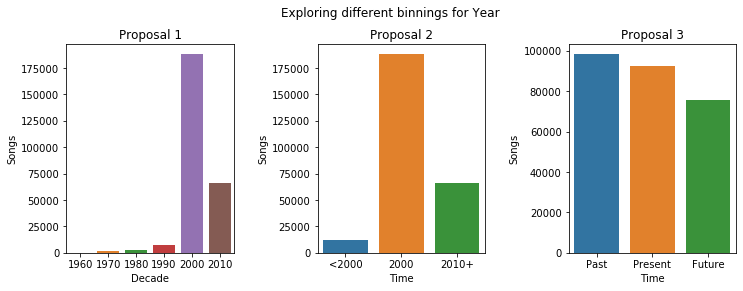

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
fig.subplots_adjust(wspace=.5, top=.85)
fig.suptitle('Exploring different binnings for Year')

plt.sca(ax[0])
plt.title('Proposal 1')
_=sns.countplot(pd.cut(data['year'],
                       bins=(1960, 1970, 1980, 1990, 2000, 2010, float('inf')),
                       labels=('1960','1970', '1980', '1990','2000','2010'))
               ).set(xlabel='Decade', ylabel='Songs')

plt.sca(ax[1])
plt.title('Proposal 2')
_=sns.countplot(pd.cut(data['year'],
                       bins=(0, 2000, 2010, float('inf')),
                       labels=('<2000','2000','2010+'))
               ).set(xlabel='Time', ylabel='Songs')

plt.sca(ax[2])
plt.title('Proposal 3')
_=sns.countplot(pd.cut(data['year'],
                       bins=(0, 2006, 2009, float('inf')),
                       labels=('Past', 'Present','Future'))
               ).set(xlabel='Time', ylabel='Songs')

In [21]:
data['year_bin'] = pd.cut(data['year'],bins=(0, 2006, 2009, float('inf')),
                          labels=('Past', 'Present','Future'))

Originally, *Proposal 1*, it was intended to bin the Year feature by decades but, after visualizing this approach, it was evident most of the songs is in the decade of the 2000s. Naively, still clinging to the idea of binning by decades, *Proposal 2* attempted to bin the data by the three most relevant decades. Still, the decade of the 2000s was too prevalent. Finally, *Proposal 3*, decided to approach binning in the following arbitrary categories:
* **Past:** From 1960 to 2006.
* **Present:** From 2006 to 2009.
* **Future:** From 2010 onwards.

## Normalize song lyrics

In [22]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

@np.vectorize
def normalize_text(text):
    text = text.lower() # lowercase 
    text = text.strip() # remove whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special characters
    # tokenize document
    tokens = wpt.tokenize(text)
    # Substitutions
    substitute = {'cause' : 'because', 'couldnt':'could not', 'youve':'you have', 'ive':'i have',
             'shes': 'she is'}
    tokens = [ # this introduces some nested lists
        substitute[token].split(' ') if token in substitute else token for token in tokens]
    tokens = [ # flatten list
        token for subtokens in (
            [token] if type(token) is str else token
            for token in tokens
        ) for token in subtokens if type(token)]

    # Apply rule filters
    rules = [(lambda token: len(token)>2 and token.endswith('in'),
              lambda token: token+'g')] # rule: [(condition, fix)]
    tokens = [rule[1](token) if rule[0](token) else token for token in tokens for rule in rules]
    # Remove stopwords and fillers
    remove = ['mmm','instrumental','x','ee','wo','rae','nee','s', 'agae']
    tokens = [token for token in tokens if token not in remove]
    tokens = [token for token in tokens if token not in stop_words]
    # Re-create document from filtered tokens
    text = ' '.join(tokens)
    return text

In [23]:
# Not enough memory to run this:
# data['lyrics_n'] = normalize_text(data['lyrics'])


lyrics = data['lyrics'].copy()
normalized_lyrics = lyrics.copy()
print('max(n)=32:', end=' ')
for n in range(int(lyrics.size/8192)+1):
    normalized_lyrics.iloc[n*8192:(n+1)*8192] = normalize_text(lyrics.iloc[n*8192:(n+1)*8192])
    print(n, end=' ')

data['lyrics'] = normalized_lyrics

max(n)=32: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

In [24]:
data['lyrics'].sample(5).map(lambda x:set(x.split()))

343109    {defendant, bout, bring, quite, earth, ya, vis...
333459    {today, leave, crazy, tank, thank, highway, fo...
215895    {calling, answers, trust, shake, remember, nam...
188921    {upside, ooh, spent, know, bloods, pretty, tim...
164738    {today, friends, saw, world, two, none, didnt,...
Name: lyrics, dtype: object

## How many unique words are there in the lyrics?

Since we will be analysing the lyrics, it will be useful to know how many unique words we're dealing with per song.

In [25]:
@np.vectorize
def number_of_unique_words(text):
    if type(text) is str:
        return len(set(text.split()))

In [26]:
unique_wc = number_of_unique_words(lyrics)
data['unique_wc'] = number_of_unique_words(data['lyrics'])

In [27]:
del(lyrics)

### Remove songs with 3 unique words or less

In [28]:
data.drop(data[data['unique_wc']<=3].index, inplace=True)

Most songs have a unique word count that is below 500.

(array([2.51448e+05, 8.59200e+03, 1.88000e+02, 2.60000e+01, 6.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([   4. ,  205.5,  407. ,  608.5,  810. , 1011.5, 1213. , 1414.5,
        1616. , 1817.5, 2019. ]),
 <a list of 10 Patch objects>)

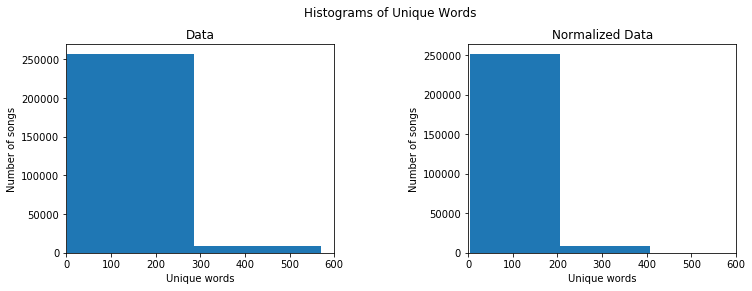

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=.5, top=.85)
fig.suptitle('Histograms of Unique Words')

plt.sca(ax[0])
plt.title('Data')
plt.xlabel('Unique words')
plt.ylabel('Number of songs')
plt.xlim(0,600)
plt.hist(unique_wc)

plt.sca(ax[1])
plt.title('Normalized Data')
plt.xlabel('Unique words')
plt.ylabel('Number of songs')
plt.xlim(0,600)
plt.hist(data['unique_wc'])

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

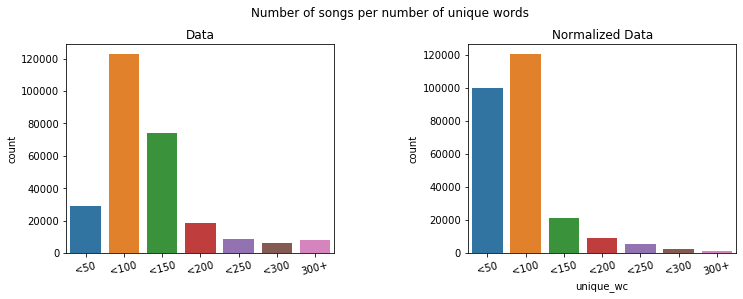

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=.5, top=.85)
fig.suptitle('Number of songs per number of unique words')

plt.sca(ax[0])
plt.title('Data')
plot_data = pd.cut(unique_wc,
                   bins=(0, 50, 100, 150, 200, 250, 300, float('inf')),
                   labels=('<50','<100', '<150', '<200','<250','<300','300+'))
sns.countplot(plot_data)
plt.xticks(rotation=15)

plt.sca(ax[1])
plt.title('Normalized Data')
plot_data = pd.cut(data['unique_wc'],
                   bins=(0, 50, 100, 150, 200, 250, 300, float('inf')),
                   labels=('<50','<100', '<150', '<200','<250','<300','300+'))
sns.countplot(plot_data)
plt.xticks(rotation=15)

In [31]:
del(unique_wc, plot_data)

Most of the songs have 150 unique words or less. And may of those that had more, had duplicate words.

### Save cleaned data

In [32]:
data.to_csv(r'data\lyrics_clean.csv', index=False)

# Data labeling

## Pre-Process Data

In [4]:
df = pd.read_csv('data/lyrics_clean.csv')

### Bigram and Trigram Models

In [81]:
data = df['lyrics'].values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])

[['oh', 'baby', 'know', 'im', 'gonna', 'cut', 'right', 'chase', 'women', 'made', 'like', 'think', 'created', 'special', 'purpose', 'know', 'whats', 'special', 'feel', 'baby', 'lets', 'get', 'lost', 'dont', 'need', 'call', 'work', 'youre', 'boss', 'real', 'want', 'show', 'feel', 'consider', 'lucky', 'thats', 'big', 'deal', 'well', 'got', 'key', 'heart', 'aint', 'gonna', 'need', 'id', 'rather', 'open', 'body', 'show', 'secrets', 'didnt', 'know', 'inside', 'need', 'lie', 'big', 'wide', 'strong', 'wont', 'fit', 'much', 'tough', 'talk', 'like', 'back', 'got', 'big', 'ego', 'huge', 'ego', 'love', 'big', 'ego', 'much', 'walk', 'like', 'back', 'usually', 'im', 'humble', 'right', 'dont', 'choose', 'leave', 'could', 'blues', 'call', 'arrogant', 'call', 'confident', 'decide', 'find', 'im', 'working', 'damn', 'know', 'im', 'killing', 'legs', 'better', 'yet', 'thighs', 'matter', 'fact', 'smile', 'maybe', 'eyes', 'boy', 'site', 'see', 'kind', 'something', 'like', 'big', 'wide', 'strong', 'wont', 'fi

In [7]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['oh', 'baby', 'know', 'im', 'gonna', 'cut', 'right', 'chase', 'women', 'made', 'like', 'think', 'created', 'special', 'purpose', 'know', 'whats', 'special', 'feel', 'baby', 'lets', 'get', 'lost', 'dont', 'need', 'call', 'work', 'youre', 'boss', 'real', 'want', 'show', 'feel', 'consider', 'lucky', 'thats', 'big', 'deal', 'well', 'got', 'key', 'heart', 'aint', 'gonna', 'need', 'id_rather', 'open', 'body', 'show', 'secrets', 'didnt', 'know', 'inside', 'need', 'lie', 'big', 'wide', 'strong', 'wont', 'fit', 'much', 'tough', 'talk', 'like', 'back', 'got', 'big_ego_huge', 'ego', 'love', 'big', 'ego', 'much', 'walk', 'like', 'back', 'usually', 'im', 'humble', 'right', 'dont', 'choose', 'leave', 'could', 'blues', 'call', 'arrogant', 'call', 'confident', 'decide', 'find', 'im', 'working', 'damn', 'know', 'im', 'killing', 'legs', 'better', 'yet', 'thighs', 'matter', 'fact', 'smile', 'maybe', 'eyes', 'boy', 'site', 'see', 'kind', 'something', 'like', 'big', 'wide', 'strong', 'wont', 'fit', 'much'

### Lemmatize Data

In [182]:
stop_words = stopwords.words('english')
def remove_stopwords(texts): #already did
    exclude = ['mmm','instrumental','x','ee','wo','rae','nee','s', 'agae']
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words and word not in exclude]
            for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [75]:
def lemmatize(data_words):
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    nlp = spacy.load('en', disable=['parser','ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized

data_lemmatized = saved_function(lemmatize, path='data/data_lemmatized.pickle', fn=lambda: lemmatize(data_words))

print(data_lemmatized[:1])

Loaded function: lemmatize at data/data_lemmatized.pickle
[['baby', 'know', 'be', 'go', 'cut', 'right', 'chase', 'woman', 'make', 'think', 'create', 'special', 'purpose', 'know', 's', 'special', 'feel', 'baby', 'let', 'get', 'lose', 'need', 'call', 'work', 'be', 'boss', 'real', 'want', 'show', 'feel', 'consider', 'lucky', 's', 'big', 'deal', 'well', 'get', 'key', 'heart', 'be', 'go', 'need', 'id_rather', 'open', 'body', 'show', 'secret', 'know', 'need', 'lie', 'big', 'wide', 'strong', 'will', 'fit', 'much', 'tough', 'talk', 'back', 'get', 'big', 'ego', 'love', 'big', 'ego', 'much', 'walk', 'back', 'usually', 'be', 'humble', 'choose', 'leave', 'could', 'blue', 'call', 'arrogant', 'call', 'confident', 'decide', 'find', 'be', 'work', 'damn', 'know', 'be', 'kill', 'leg', 'better', 'yet', 'thigh', 'matter', 'fact', 'smile', 'maybe', 'eye', 'boy', 'site', 'see', 'kind', 'big', 'wide', 'strong', 'will', 'fit', 'much', 'tough', 'talk', 'back', 'get', 'big', 'ego', 'love', 'big', 'ego', 'much',

### Create Dictionary and Corpus

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## Topic Modelling

In [35]:
from helpers.saved_data import SavedModel

### LDA Models

In [5]:
lda4 = SavedLabelModel(
    model_class = LdaModel,
    path = 'models/label_lda4.model',
    train_fn = lambda: LdaModel(
        corpus = corpus,
        id2word = id2word,
        num_topics = 4, 
        random_state = 100,
        update_every = 1,
        passes = 10,
        alpha = 'auto',
        per_word_topics = True))

Loaded model: LdaModel at models/gensim_lda4.model


In [12]:
lda4m = SavedLabelModel(
    model_class = LdaMulticore,
    path = 'models/label_lda4m.model',
    train_fn = lambda: LdaMulticore(
        corpus = corpus,
        id2word = id2word,
        num_topics = 4, 
        random_state = 100,
        passes = 10,
        per_word_topics = True,
        workers = 3))

Loaded model: LdaMulticore at models/gensim_lda4m.model


In [36]:
lda10 = SavedLabelModel(
    model_class = LdaModel,
    path = 'models/label_lda10.model',
    train_fn = lambda: LdaModel(
        corpus = corpus,
        id2word = id2word,
        num_topics = 10, 
        random_state = 100,
        update_every = 1,
        passes = 10,
        alpha = 'auto',
        per_word_topics = True))

Loaded model: LdaModel at models/gensim_lda10.model


In [14]:
lda10m = SavedLabelModel(
    model_class = LdaMulticore,
    path = 'models/label_lda10m.model',
    train_fn = lambda: LdaMulticore(
        corpus = corpus,
        id2word = id2word,
        num_topics = 10, 
        random_state = 100,
        passes = 10,
        per_word_topics = True,
        workers = 3))

Loaded model: LdaMulticore at models/gensim_lda10m.model


In [15]:
lda20 = SavedLabelModel(
    model_class = LdaModel,
    path = 'models/label_lda20.model',
    train_fn = lambda: LdaModel(
        corpus = corpus,
        id2word = id2word,
        num_topics = 20, 
        random_state = 100,
        update_every = 1,
        passes = 10,
        alpha = 'auto',
        per_word_topics = True))

Loaded model: LdaModel at models/gensim_lda20.model


In [16]:
lda20m = SavedLabelModel(
    model_class = LdaMulticore,
    path = 'models/label_lda20m.model',
    train_fn = lambda: LdaMulticore(
        corpus = corpus,
        id2word = id2word,
        num_topics = 20, 
        random_state = 100,
        passes = 10,
        per_word_topics = True,
        workers = 3))

Loaded model: LdaMulticore at models/gensim_lda20m.model


In [17]:
lda30 = SavedLabelModel(
    model_class = LdaModel,
    path = 'models/label_lda30.model',
    train_fn = lambda: LdaModel(
        corpus = corpus,
        d2word = id2word,
        num_topics = 30, 
        random_state = 100,
        update_every = 1,
        passes = 10,
        alpha = 'auto',
        per_word_topics = True))

Loaded model: LdaModel at models/gensim_lda30.model


In [18]:
lda30m = SavedLabelModel(
    model_class = LdaMulticore,
    path = 'models/label_lda30m.model',
    train_fn = lambda: LdaMulticore(
        corpus = corpus,
        id2word = id2word,
        num_topics = 30, 
        random_state = 100,
        passes = 10,
        per_word_topics = True,
        workers = 3))

Loaded model: LdaMulticore at models/gensim_lda30m.model


### LSI Model

In [19]:
lsi20 = SavedLabelModel(
    model_class = LsiModel,
    path = 'models/label_lsi20.model',
    train_fn = lambda: gensim.models.LsiModel(
        corpus = corpus,
        num_topics = 20,
        id2word = id2word,
        chunksize = 20000))

Loaded model: LsiModel at models/gensim_lsi20.model


In [20]:
lsi30 = SavedLabelModel(
    model_class = LsiModel,
    path = 'models/label_lsi30.model',
    train_fn = lambda: gensim.models.LsiModel(
        corpus = corpus,
        num_topics = 30,
        id2word = id2word,
        chunksize = 20000))

Loaded model: LsiModel at models/gensim_lsi30.model


### HDP Model

In [21]:
hdp = SavedLabelModel(
    model_class = HdpModel,
    path = 'models/label_hdp.model',
    train_fn = lambda: HdpModel(
        corpus=corpus,
        id2word=id2word,
        random_state=100))

Loaded model: HdpModel at models/gensim_hdp.model


In [22]:
# Retrain models
for model in SavedModel.models:
    #model.train(retrain=True)
    pass

Saved model: LdaModel at models/gensim_lda4.model
Saved model: LdaMulticore at models/gensim_lda4m.model
Saved model: LdaModel at models/gensim_lda10.model
Saved model: LdaMulticore at models/gensim_lda10m.model
Saved model: LdaModel at models/gensim_lda20.model
Saved model: LdaMulticore at models/gensim_lda20m.model
Saved model: LdaModel at models/gensim_lda30.model
Saved model: LdaMulticore at models/gensim_lda30m.model
Saved model: LsiModel at models/gensim_lsi20.model
Saved model: LsiModel at models/gensim_lsi30.model
Saved model: HdpModel at models/gensim_hdp.model


### Model comparison

In [23]:
for model in SavedModel.models:
    model.get_coherence()

Coherence for lda4: 0.3907475376049967
Coherence for lda4m: 0.3667693370522911
Coherence for lda10: 0.4007291709350416
Coherence for lda10m: 0.38745472096276057
Coherence for lda20: 0.32950601242727434
Coherence for lda20m: 0.4076288538686087
Coherence for lda30: 0.3677393888906635
Coherence for lda30m: 0.3896450219810855
Coherence for lsi20: 0.3327589076113605
Coherence for lsi30: 0.3327589076113605
Coherence for hdp: 0.44124865571427563


In [24]:
# To-do: Remake this plot without the function

def  evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.xticks(rotation=90)

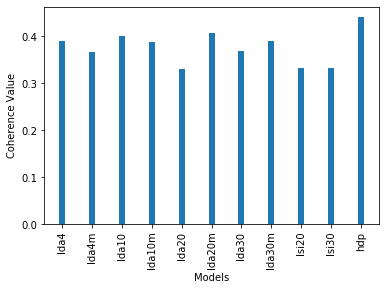

In [25]:
evaluate_bar_graph([model.get_coherence() for model in SavedModel.models],
                  [model.name for model in SavedModel.models])

### Selected Model: LDA10

#### Model output

In [14]:
lda10.model.print_topics()

[(0,
  '0.072*"die" + 0.020*"black" + 0.018*"kill" + 0.017*"blood" + 0.014*"war" + 0.014*"death" + 0.014*"fight" + 0.009*"shall" + 0.008*"hate" + 0.008*"ee"'),
 (1,
  '0.302*"come" + 0.141*"back" + 0.084*"good" + 0.069*"home" + 0.051*"bring" + 0.024*"town" + 0.016*"mother" + 0.011*"around" + 0.008*"god" + 0.007*"heavy"'),
 (2,
  '0.108*"be" + 0.095*"get" + 0.020*"man" + 0.017*"make" + 0.014*"little" + 0.012*"take" + 0.012*"say" + 0.012*"put" + 0.012*"know" + 0.011*"talk"'),
 (3,
  '0.025*"world" + 0.024*"life" + 0.023*"eye" + 0.023*"away" + 0.022*"fall" + 0.021*"dream" + 0.016*"live" + 0.016*"light" + 0.015*"take" + 0.014*"heart"'),
 (4,
  '0.075*"love" + 0.075*"be" + 0.068*"know" + 0.039*"want" + 0.033*"can" + 0.031*"say" + 0.030*"make" + 0.028*"feel" + 0.028*"never" + 0.025*"ill"'),
 (5,
  '0.035*"money" + 0.029*"shit" + 0.027*"bitch" + 0.022*"fuck" + 0.018*"hit" + 0.014*"real" + 0.013*"rhyme" + 0.012*"eat" + 0.011*"check" + 0.011*"ass"'),
 (6,
  '0.376*"go" + 0.149*"let" + 0.044*"ni

#### Interactive Model Exploration

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda10.model, corpus=corpus, dictionary=id2word)

c:\program files\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.232799 -0.011130       1        1  22.871206
4      0.289948 -0.047315       2        1  21.672102
2      0.249677  0.023065       3        1  19.021706
3      0.126320 -0.012012       4        1  15.232125
6     -0.083978 -0.146942       5        1   5.286791
5     -0.113123  0.269959       6        1   4.472774
0     -0.120522  0.255201       7        1   4.231965
1     -0.178558 -0.262689       8        1   3.625547
7     -0.193125 -0.009269       9        1   2.481477
9     -0.209438 -0.058869      10        1   1.104303, topic_info=     Category           Freq      Term          Total  loglift  logprob
31    Default  459612.000000        go  459612.000000  30.0000  30.0000
84    Default  253069.000000      come  253069.000000  29.0000  29.0000
4     Default  850678.000000        be  850678.000000  28.0000  28.0000
30    Default  418487.000000       get  418487.000000  27.0000  27.0000
44    Default  375753.000000      love  375753.000000  26.0000  26.0000
...       ...            ...       ...            ...      ...      ...
894   Topic10     834.053101  overcome     834.997253   4.5048  -5.7243
3780  Topic10     818.948975      rust     819.893127   4.5048  -5.7426
7090  Topic10     815.330688      alzo     816.274597   4.5048  -5.7470
2341  Topic10     810.201904      sour     811.146057   4.5048  -5.7533
923   Topic10    5345.142090       son   12479.447266   3.6580  -3.8666

[499 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
80        3  0.999882        act
736       2  0.999533  affection
126       1  0.999889       agae
126       2  0.000109       agae
2419      6  0.999753        age
...     ...       ...        ...
125       1  0.134563      wrong
125       2  0.865404      wrong
2153     10  0.999832        yea
898       1  0.999967       year
1695      9  0.999650     yellow

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 3, 4, 7, 6, 1, 2, 8, 10])

#### Topic Labeling

In [50]:
def dominant_topic(n, corpus=corpus, model=lda10.model, topic_n=False):
    topics = {
        0: 'death',      #  7
        1: 'home',       #  8
        2: 'man',        #  3
        3: 'life',       #  4
        4: 'love',       #  2
        5: 'money',      #  6
        6: 'party',      #  5
        7: 'woman',      #  9
        8: 'friend',     #  1
        9: 'sing'        # 10
    }
    #probabilites: lda10.model[corpus[345]][2][0][1] # to extract all topics, could add each to a column
    try:
        topic = model[corpus[n]][1][0][1][0]
    except IndexError:
        return np.nan
    if topic_n:
        return topic
    return topics[topic]

In [219]:
df['topic'] = pd.Series()
for n in range(len(corpus)):
    df.iloc[n,-1] = dominant_topic(n)

### Drop colums without a topic

In [249]:
print(f"There are {df.loc[df['topic'].isnull()].shape[0]:,} song lyrics without a topic.")

There are 0 song lyrics without a topic.


In [244]:
df.dropna(inplace=True)

### Visualize the topic distribution

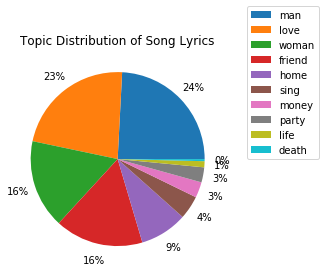

In [78]:
plt.title('Topic Distribution of Song Lyrics')
plt.pie(df['topic'].value_counts(),
        autopct='%1.0f%%',
        pctdistance=1.2)
plt.legend(df['topic'].unique(),
           loc = 'center right',
           bbox_to_anchor=(1.45 ,0.85))

Text(0.5, 1.0, 'Topic Distribution of Song Lyrics')

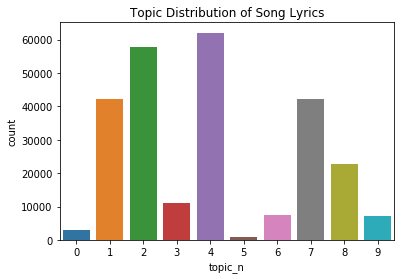

In [77]:
sns.countplot(x=df['topic_n'])
plt.title('Topic Distribution of Song Lyrics')
#plt.legend(df['topic'].unique(),
#           loc = 'center right',
#           bbox_to_anchor=(1.45 ,0.85))

### Save the labeled data

In [ ]:
df.to_csv(r'data\lyrics_labeled.csv', index=False)

# Feature Engineering

### Set constants

In [3]:
N_WORDS = 10
RANDOM_STATE = 100

### Load the data

In [4]:
df = pd.read_csv('data/lyrics_labeled.csv')
#df = df.sample(frac=0.05, random_state=100)
df.shape

(256608, 9)

## Feature Extraction

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

stop_words = stopwords.words('english')
def remove_stopwords(texts): #already did
    exclude = ['mmm','instrumental','x','ee','wo','rae','nee','s', 'agae']
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words and word not in exclude]
            for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 

        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [6]:
if df.shape[0] == 256608:
    #data = df['lyrics'].values.tolist()
    def lemmatize(data):
        def sent_to_words(sentences):
            for sentence in sentences:
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        data_words = list(sent_to_words(data))
        data_words_nostops = remove_stopwords(data_words)
        data_words_bigrams = make_bigrams(data_words_nostops)
        nlp = spacy.load('en', disable=['parser','ner'])
        data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        return data_lemmatized

    data_lemmatized = saved_function(lemmatize, path='data/data_lemmatized2.pickle', fn=lambda: lemmatize(data_words))
else:
    data = df['lyrics'].values.tolist()
    data_words = list(sent_to_words(data))

    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en', disable=['parser','ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

Loaded function: lemmatize at data/data_lemmatized2.pickle
[['baby', 'know', 'be', 'go', 'cut', 'right', 'chase', 'woman', 'make', 'think', 'create', 'special', 'purpose', 'know', 's', 'special', 'feel', 'baby', 'let', 'get', 'lose', 'need', 'call', 'work', 'be', 'boss', 'real', 'want', 'show', 'feel', 'consider', 'lucky', 's', 'big', 'deal', 'well', 'get', 'key', 'heart', 'be', 'go', 'need', 'id_rather', 'open', 'body', 'show', 'secret', 'know', 'need', 'lie', 'big', 'wide', 'strong', 'will', 'fit', 'much', 'tough', 'talk', 'back', 'get', 'big', 'ego', 'huge', 'ego', 'love', 'big', 'ego', 'much', 'walk', 'back', 'usually', 'be', 'humble', 'choose', 'leave', 'could', 'blue', 'call', 'arrogant', 'call', 'confident', 'decide', 'find', 'be', 'work', 'damn', 'know', 'be', 'kill', 'leg', 'better', 'yet', 'thigh', 'smile', 'maybe', 'eye', 'boy', 'site', 'see', 'kind', 'big', 'wide', 'strong', 'will', 'fit', 'much', 'tough', 'talk', 'back', 'get', 'big', 'ego', 'huge', 'ego', 'love', 'big', '

In [7]:
norm_corpus = [' '.join(token_list) for token_list in data_lemmatized]

### Features Dataframe

Remove nonwords and empty rows

In [8]:
def remove_nonwords(corpus):
    # can't vectorize, not enough memory
    words = corpus.split(' ')
    remove = ['s', 'ee', 'nee', 'wo', 'rae', 'agae', 'pae']
    words = [word for word in words if word not in remove]
    return ' '.join(words)

for n in range(len(norm_corpus)):
    norm_corpus[n] = remove_nonwords(norm_corpus[n])

corpus_df = pd.DataFrame({'corpus':pd.Series(norm_corpus),'topic':df['topic']})

# Remove emtpy rows
corpus_df.drop((corpus_df[corpus_df['corpus']=='']).index, inplace=True)
corpus_df = corpus_df.reset_index(drop=True)

## Baseline Feature Selection: Random Pick

In [9]:
def feasel_random(corpus, n_words=5, random_state=None, join_words=True):
    '''Selects a n_words words at random. norm_corpus if join_words else data_lemmatized'''
    if random_state is not None:
        random.seed(random_state)
    unique_words = list(set(corpus.split(' ')))
    if len(unique_words) <= n_words:
        words = unique_words
    else:
        words = []
        while len(words) < n_words:
            words.append(random.choice(unique_words))
    if join_words:
        return ' '.join(words)
    else:
        return words

In [10]:
feasel_data_lemmatized = [
    feasel_random(corpus,
                  n_words=N_WORDS,
                  random_state=RANDOM_STATE,
                  join_words=False)
    for index, corpus, topic in corpus_df.itertuples()]

### Preprocess data

In [11]:
X = feasel_data_lemmatized
y = corpus_df['topic']

id2word = corpora.Dictionary(X)
word2id=dict((word,id) for id,word in id2word.items())
# encode X and y
X = [[word2id[word] for word in corpus] for corpus in X]
y = pd.Series((word2id[word] for word in y), name='topic')

feasel_df = pd.DataFrame(X, dtype='int64')
feasel_df.rename(columns=dict((cn,'x'+str(cn)) for cn in feasel_df.columns), inplace = True)
feasel_df['y'] = y
feasel_df.dropna(inplace = True)

### Split into train/test data

In [12]:
feasel_X_train, feasel_X_test, feasel_y_train, feasel_y_test = train_test_split(feasel_df.iloc[:,:-1], feasel_df.iloc[:,-1])
len(feasel_X_train), len(feasel_y_train)

(182788, 182788)

### Metric: DecisionTreeClassifier

In [13]:
base_tree = DecisionTreeClassifier()
base_tree.fit(feasel_X_train, feasel_y_train)
base_tree.score(feasel_X_test, feasel_y_test)

0.3125882159855572

### Metric: ExtraTreesClassifier

In [14]:
base_trees = ExtraTreesClassifier()
base_trees.fit(feasel_X_train, feasel_y_train)
base_trees.score(feasel_X_test, feasel_y_test)

0.3521253897915641

### Selected Metric: RandomForestClassifier

In [15]:
base_rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
base_rfc.fit(feasel_X_train, feasel_y_train)
base_rfc.score(feasel_X_test, feasel_y_test)

0.4032496307237814

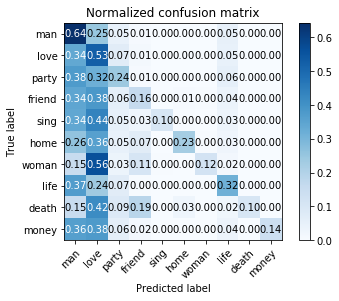

In [16]:
plot_confusion_matrix(feasel_y_test,
                      base_rfc.predict(feasel_X_test),
                      classes=[id2word[wid] for wid in feasel_y_test.unique()])

## Feature Selection: GloVe

In [35]:
nlp = spacy.load('en_vectors_web_lg') #glove
print(f'Total word vectors: {len(nlp.vocab.vectors):,}')

Total word vectors: 1,070,971


In [18]:
def feasel_glove(corpus, topic, glove_model, n_words=5, random_state=None, join_words=True):
    '''From the corpus, find the n_words closest to topic using glove.similarity'''
    if random_state is not None:
        random.seed(random_state)
    unique_words = list(set(corpus.split(' ')))
    if len(unique_words) <= n_words:
        words = unique_words
    else:
        words = [word[0] for word in sorted(
            {(word, nlp(word).similarity(nlp(topic)))
             for word in corpus.split(' ')
             if word in glove_model.vocab},
            key=lambda x:abs(x[1]), reverse=True)][:n_words]
    if join_words:
        return ' '.join(words)
    else:
        return words

In [19]:
feasel_data_lemmatized = [
    feasel_glove(corpus,
                 topic,
                 nlp,
                 n_words=N_WORDS,
                 random_state=RANDOM_STATE,
                 join_words=False)
    for index, corpus, topic in corpus_df.itertuples()]

### Preprocess data

In [20]:
X = feasel_data_lemmatized
y = corpus_df['topic']

id2word = corpora.Dictionary(X)
word2id=dict((word,id) for id,word in id2word.items())
# encode X and y
X = [[word2id[word] for word in corpus] for corpus in X]
y = pd.Series((word2id[word] for word in y), name='topic')

feasel_df = pd.DataFrame(X, dtype='int64')
feasel_df.rename(columns=dict((cn,'x'+str(cn)) for cn in feasel_df.columns), inplace = True)
feasel_df['y'] = y
feasel_df.dropna(inplace = True)

### Split into train/test

In [21]:
feasel_X_train, feasel_X_test, feasel_y_train, feasel_y_test = train_test_split(feasel_df.iloc[:,:-1], feasel_df.iloc[:,-1], random_state=RANDOM_STATE)
len(feasel_X_train), len(feasel_y_train)

(181400, 181400)

### Metric: RandomForestClassifier

In [22]:
base_rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
base_rfc.fit(feasel_X_train, feasel_y_train)
base_rfc.score(feasel_X_test, feasel_y_test)

0.9120512014818

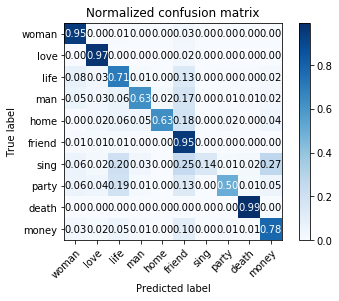

In [23]:
plot_confusion_matrix(feasel_y_test,
                      base_rfc.predict(feasel_X_test),
                      classes=[id2word[wid] for wid in feasel_y_test.unique()])

## Selected Feature Selection: Word2Vec

In [24]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(lyrics) for lyrics in norm_corpus]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30   # Context window size                                                                                    
min_word_count = 1    # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)
print(f'Size of vocabulary: {len(w2v_model.wv.vocab):,}')

Size of vocabulary: 178,130


In [25]:
def feasel_w2v(corpus, topic, w2v_model, n_words=5, random_state=None, join_words=True):
    '''From the corpus, find the n_words closest to topic using word2vec.similarity'''
    if random_state is not None:
        random.seed(random_state)
    unique_words = list(set(corpus.split(' ')))
    if len(unique_words) <= n_words:
        words = unique_words
    else:
        #check if it's better with or without abs in the key
        words = [word[0] for word in sorted(
            {(word, w2v_model.similarity(topic, word))
             for word in corpus.split(' ')
             if word in w2v_model.wv},
            key=lambda x:abs(x[1]), reverse=True)][:n_words]
    if join_words:
        return ' '.join(words)
    else:
        return words

In [27]:
feasel_data_lemmatized = saved_function(
    feasel_w2v, retrain = False,
    path = 'data/fs_data_lemmatized.pickle',
    fn = lambda: [
        feasel_w2v(corpus,
                   topic,
                   w2v_model,
                   n_words=N_WORDS,
                   random_state=RANDOM_STATE,
                   join_words=False)
        for index, corpus, topic in corpus_df.itertuples()]
)

Saved function: feasel_w2v at data/fs_data_lemmatized.pickle


In [28]:
feasel_norm_corpus = saved_function(
    feasel_w2v, retrain = False,
    path = 'data/fs_norm_corpus.pickle',
    fn = lambda: [
        feasel_w2v(corpus,
                   topic,
                   w2v_model,
                   n_words=N_WORDS,
                   random_state=RANDOM_STATE,
                   join_words=True)
        for index, corpus, topic in corpus_df.itertuples()]
)

Saved function: feasel_w2v at data/fs_norm_corpus.pickle


### Preprocess data

In [29]:
X = feasel_data_lemmatized
y = corpus_df['topic']

id2word = corpora.Dictionary(X)
word2id=dict((word,id) for id,word in id2word.items())
# encode X and y
X = [[word2id[word] for word in corpus] for corpus in X]
y = pd.Series((word2id[word] for word in y), name='topic')

feasel_df = pd.DataFrame(X, dtype='int64')
feasel_df.rename(columns=dict((cn,'x'+str(cn)) for cn in feasel_df.columns), inplace = True)
feasel_df['y'] = y
feasel_df.dropna(inplace = True)

### Split into train/test

In [30]:
feasel_X_train, feasel_X_test, feasel_y_train, feasel_y_test = train_test_split(feasel_df.iloc[:,:-1], feasel_df.iloc[:,-1], random_state=RANDOM_STATE)
len(feasel_X_train), len(feasel_y_train)

(182788, 182788)

### Metric: RandomForestClassifier

In [31]:
base_rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
base_rfc.fit(feasel_X_train, feasel_y_train)
base_rfc.score(feasel_X_test, feasel_y_test)

0.9492532414245856

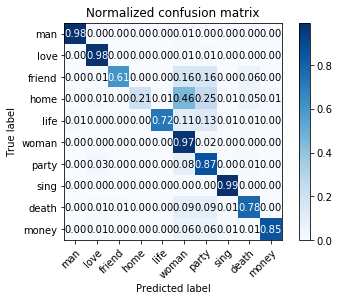

In [32]:
plot_confusion_matrix(feasel_y_test,
                      base_rfc.predict(feasel_X_test),
                      classes=[id2word[wid] for wid in feasel_y_test.unique()])

In [34]:
# save vocabulary to a file here
with open('data/fs_data_lemmatized.pickle', 'wb') as f:
    pickle.dump(feasel_data_lemmatized, f)

with open('data/fs_norm_corpus.pickle', 'wb') as f:
    pickle.dump(feasel_norm_corpus, f)
    
corpus_df['topic'].to_csv(r'data\topics.csv', index=False)

# Machine Learning implementation

## Prepare the environment

In [2]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from mlxtend.plotting import plot_learning_curves, plot_decision_regions

#keras skip
from keras.layers import Input, Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model, load_model
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams

#keras cbow
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.layers import Input, Dot, Flatten, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier # try to use use sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import imblearn
from imblearn.combine import SMOTETomek

Using TensorFlow backend.


### Set Constants

In [6]:
N_ESTIMATORS = 20
RANDOM_STATE = 100
RETRAIN = False

### Load the features and tokenize

In [7]:
with open('data/fs_data_lemmatized.pickle', 'rb') as f:
    feasel_data_lemmatized = pickle.load(f)

topics = pd.read_csv('data/topics.csv', header=None).rename(columns={0:'topic'})

In [8]:
X = feasel_data_lemmatized
y = topics['topic']

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(X)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
#word2id=dict((word,id) for id,word in id2word.items())
# encode X and y
X = [[word2id[word] for word in corpus] for corpus in X]
y = pd.Series((word2id[word] for word in y), name='topic')

vocab_size = len(word2id)

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

feasel_df = pd.DataFrame(X, dtype='int64')
feasel_df.rename(columns=dict((cn,'x'+str(cn)) for cn in feasel_df.columns), inplace = True)
feasel_df['y'] = y
feasel_df.dropna(inplace = True)

print(feasel_df.shape)

Vocabulary Size: 58489
Vocabulary Sample: [('know', 1), ('love', 2), ('go', 3), ('get', 4), ('back', 5), ('baby', 6), ('feel', 7), ('want', 8), ('tell', 9), ('be', 10)]
(243718, 11)


## Rebalance the data

### Rebalance with SMOTE + Tomek

In [40]:
smt = SMOTETomek(sampling_strategy ='auto')
X_smt, y_smt = smt.fit_sample(feasel_df.iloc[:,:-1], feasel_df.iloc[:,-1])

In [67]:
bal_df = pd.DataFrame(X_smt, dtype='int64')
bal_df['y'] = y_smt
bal_df.dropna(inplace = True)
bal_df.shape

(589072, 11)

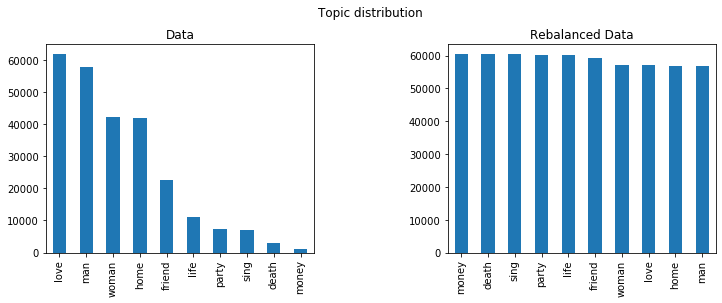

In [101]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.subplots_adjust(wspace=.5, top=.85)
fig.suptitle('Topic distribution')

plt.sca(ax[0])
plt.title('Data')
plt.xticks(rotation=45)
topics['topic'].value_counts().plot(kind='bar')

plt.sca(ax[1])
plt.title('Rebalanced Data')
plt.xticks(rotation=45)
pd.Series(np.vectorize(lambda wid: id2word[wid])(bal_df['y'])).value_counts().plot(kind='bar')

In [69]:
bal_df.to_csv(r'data/features_balanced.csv', index=False)

## Baseline: Random Guess + Simple Rule

In [7]:
model_df = pd.read_csv('data/features_balanced.csv')

In [168]:
X = model_df.iloc[:,:-1]
y = np.vectorize(lambda wid: id2word[wid])(model_df.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
len(X_train), len(y_train)

(441804, 441804)

In [9]:
help(RGSR)

Help on class RGSR in module helpers.RGSR:

class RGSR(builtins.object)
 |  RGSR(random_state=None)
 |  
 |  Predicts topic at random based on the distribution of the train data
 |  
 |  Methods defined here:
 |  
 |  __init__(self, random_state=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X=None, y=None)
 |      Generate the distrubution of topics. X is ignored.
 |  
 |  predict(self, y=None)
 |      Select the topic whose distribution is closest to a random number
 |  
 |  transform(self, y)
 |      Produce a y.shape vector of predictions
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



### Balanced data

In [169]:
model = RGSR(random_state=100)
model.fit(X_train, y_train)
y_pred = model.transform(y_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
scores

{'accuracy_score': 0.09700002716136567,
 'balanced_accuracy_score': 0.10029822279894066,
 'f1_score': 0.02769405080687871,
 'precision_score': 0.10625791369780777,
 'recall_score': 0.09700002716136567}

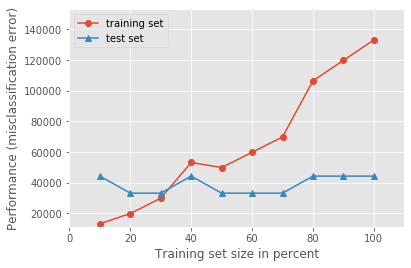

In [136]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

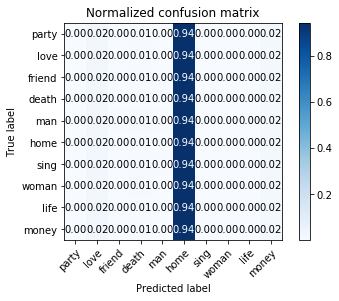

In [137]:
y_pred = pd.Series(model.transform(y_test))
y_pred.index = y_test.index
plot_confusion_matrix(y_test,
                      y_pred, # model ignores X but needs shape of y
                      classes=y_test.unique())

### Unbalanced data

In [185]:
model = RGSR(random_state=100)
model.fit(X_train, y_train)
y_pred = model.transform(y_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
scores

{'accuracy_score': 0.12399474807155753,
 'balanced_accuracy_score': 0.09690126978474742,
 'f1_score': 0.1283176902088612,
 'precision_score': 0.1858146670287306,
 'recall_score': 0.12399474807155753}

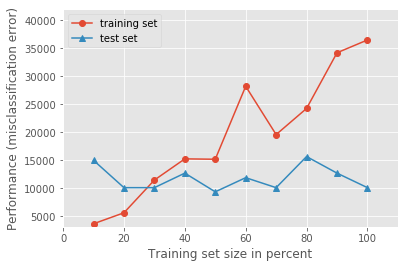

In [186]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

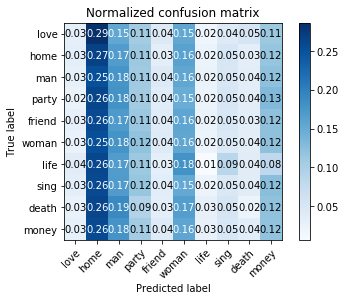

In [187]:
y_pred = pd.Series(model.transform(y_test))
y_pred.index = y_test.index
plot_confusion_matrix(y_test,
                      y_pred, # model ignores X but needs shape of y
                      classes=y_test.unique())

## Ensemble model

In [6]:
model_df = pd.read_csv('data/features_balanced.csv')

In [7]:
X = model_df.iloc[:,:-1]
y = model_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
len(X_train), len(y_train)

(441804, 441804)

In [8]:
#Reference (cant run stacked with 100 estimators)
model_ETC100 = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE)
model_RFC100 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

#ExtraTrees
model_ETC = ExtraTreesClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
model_ETCb = BaggingClassifier(base_estimator = model_ETC, n_estimators=N_ESTIMATORS,
                               max_samples=0.8, max_features=0.8, random_state=RANDOM_STATE)
model_ETCbb = AdaBoostClassifier(base_estimator = model_ETC, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
#RandomForest
model_RFC = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
model_RFCb = BaggingClassifier(base_estimator = model_RFC, n_estimators=N_ESTIMATORS,
                               max_samples=0.8, max_features=0.8, random_state=RANDOM_STATE)
model_RFCbb = AdaBoostClassifier(base_estimator = model_RFC, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

model_STA = StackingClassifier(estimators=[('ETCbb', model_ETCbb), ('RFCbb', model_RFCbb)])

model_scores = {}
#scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
#print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')

In [9]:
model = model_ETC100

model = saved_function(
    model,
    path='C:/temp/ensemble_etc100.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['ETC100'] = scores
scores

Loaded function: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> at C:/temp/ensemble_etc100.model


{'accuracy_score': 0.9342083819974468,
 'balanced_accuracy_score': 0.9334586635887122,
 'f1_score': 0.9338592224064676,
 'precision_score': 0.9342861322511443,
 'recall_score': 0.9342083819974468}

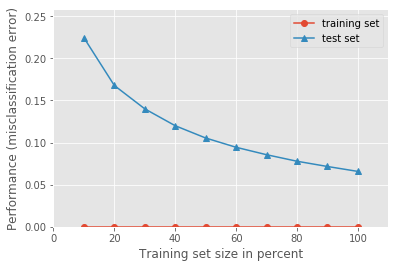

In [10]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

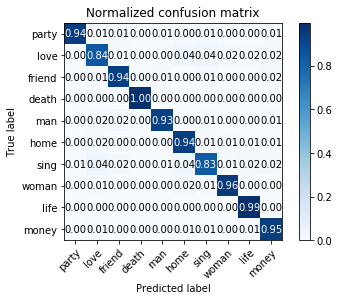

In [11]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [12]:
model = model_ETC

model = saved_function(
    model,
    path='C:/temp/ensemble_etc.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['ETC'] = scores
scores

Loaded function: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> at C:/temp/ensemble_etc.model


{'accuracy_score': 0.8988171225249205,
 'balanced_accuracy_score': 0.8980533189756095,
 'f1_score': 0.898190447152536,
 'precision_score': 0.8987004712168499,
 'recall_score': 0.8988171225249205}

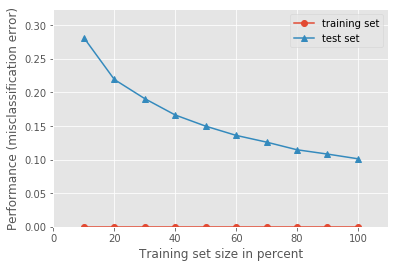

In [13]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

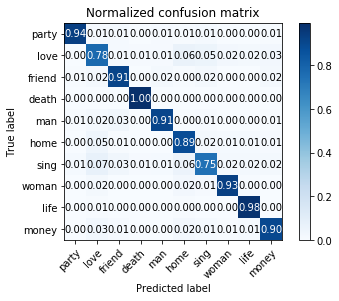

In [14]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [15]:
model = model_ETCb

model = saved_function(
    model,
    path='C:/temp/ensemble_etcb.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['ETCb'] = scores
scores

Loaded function: <class 'sklearn.ensemble._bagging.BaggingClassifier'> at C:/temp/ensemble_etcb.model


{'accuracy_score': 0.9240432408941521,
 'balanced_accuracy_score': 0.9232942688615392,
 'f1_score': 0.9234457650182455,
 'precision_score': 0.9246246533326756,
 'recall_score': 0.9240432408941521}

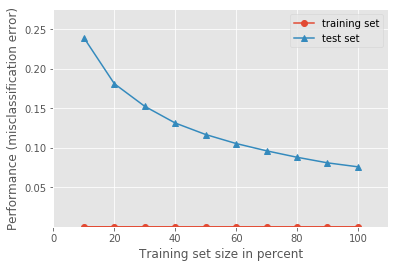

In [16]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

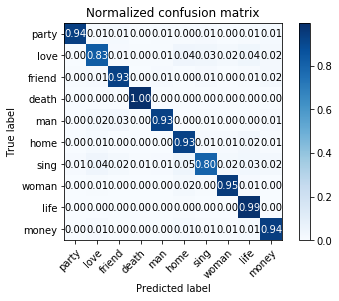

In [17]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [18]:
model = model_ETCbb

model = saved_function(
    model,
    path='C:/temp/ensemble_etcbb.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['ETCbb'] = scores
scores

Loaded function: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> at C:/temp/ensemble_etcbb.model


{'accuracy_score': 0.8940299318249721,
 'balanced_accuracy_score': 0.8932307185432691,
 'f1_score': 0.8935695830527292,
 'precision_score': 0.8941927618492285,
 'recall_score': 0.8940299318249721}

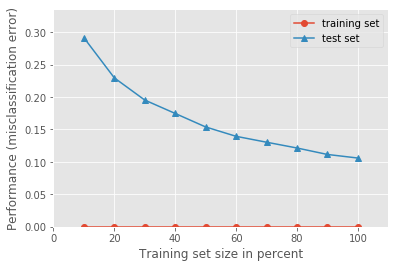

In [19]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

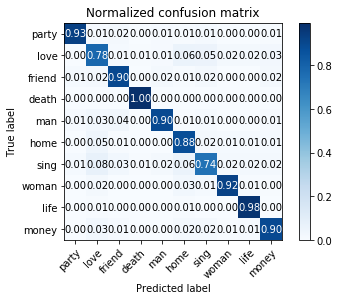

In [20]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [21]:
model = model_RFC100

model = saved_function(
    model,
    path='C:/temp/ensemble_rfc100.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['RFC100'] = scores
scores

Loaded function: <class 'sklearn.ensemble._forest.RandomForestClassifier'> at C:/temp/ensemble_rfc100.model


{'accuracy_score': 0.8982942662357063,
 'balanced_accuracy_score': 0.8982138300868854,
 'f1_score': 0.8981090528781015,
 'precision_score': 0.8990435803731269,
 'recall_score': 0.8982942662357063}

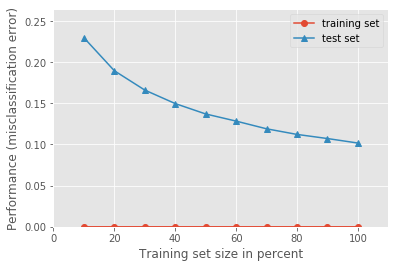

In [22]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

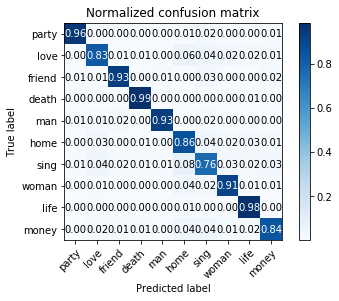

In [23]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [24]:
model = model_RFC

model = saved_function(
    model,
    path='C:/temp/ensemble_rfc.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['RFC'] = scores
scores

Loaded function: <class 'sklearn.ensemble._forest.RandomForestClassifier'> at C:/temp/ensemble_rfc.model


{'accuracy_score': 0.8823573349268001,
 'balanced_accuracy_score': 0.882433820707005,
 'f1_score': 0.8819630253218637,
 'precision_score': 0.8827343835275087,
 'recall_score': 0.8823573349268001}

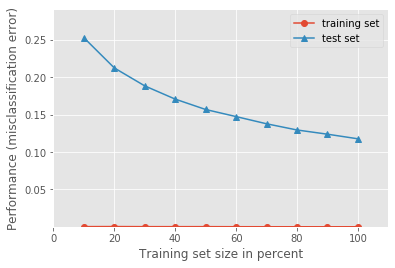

In [25]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

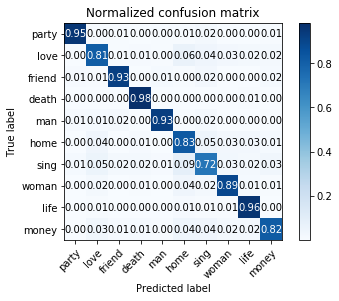

In [26]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [27]:
model = model_RFCb

model = saved_function(
    model,
    path='C:/temp/ensemble_rfcb.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['RFCb'] = scores
scores

Loaded function: <class 'sklearn.ensemble._bagging.BaggingClassifier'> at C:/temp/ensemble_rfcb.model


{'accuracy_score': 0.8954626938642475,
 'balanced_accuracy_score': 0.8954169482462779,
 'f1_score': 0.8949207721953251,
 'precision_score': 0.896233149280046,
 'recall_score': 0.8954626938642475}

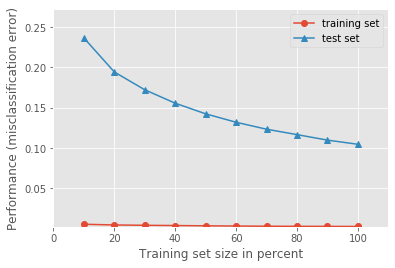

In [28]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

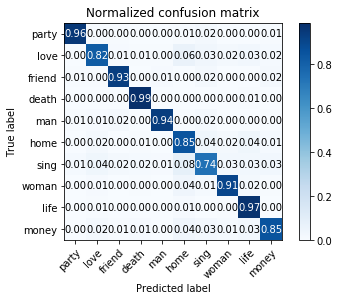

In [29]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [30]:
model = model_RFCbb

model = saved_function(
    model,
    path='C:/temp/ensemble_rfcbb.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['RFCbb'] = scores
scores

Loaded function: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> at C:/temp/ensemble_rfcbb.model


{'accuracy_score': 0.9203425048211424,
 'balanced_accuracy_score': 0.9197423888501379,
 'f1_score': 0.9209925075964699,
 'precision_score': 0.922284866705204,
 'recall_score': 0.9203425048211424}

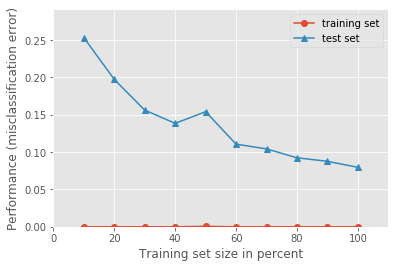

In [31]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

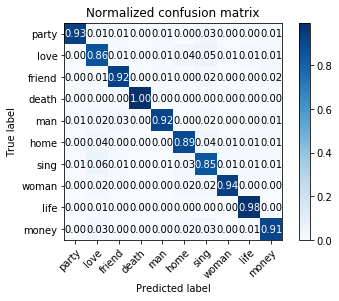

In [32]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [33]:
model = model_STA

model = saved_function(
    model,
    path='C:/temp/ensemble_sta.model',
    fn= lambda: model.fit(X_train, y_train),
    retrain=RETRAIN)

y_pred = model.predict(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(y_test, y_pred)
    else:
        scores[score.__name__] = score(y_test, y_pred, average='weighted')
model_scores['STA'] = scores
scores

Loaded function: <class 'sklearn.ensemble._stacking.StackingClassifier'> at C:/temp/ensemble_sta.model


{'accuracy_score': 0.9289187060325393,
 'balanced_accuracy_score': 0.9283022704646579,
 'f1_score': 0.9292704962482229,
 'precision_score': 0.9297897564814737,
 'recall_score': 0.9289187060325393}

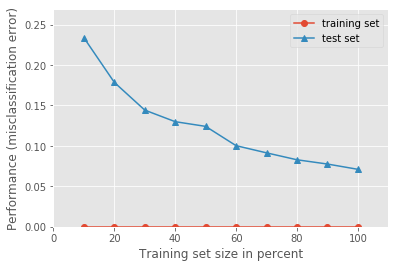

In [34]:
fig = plot_learning_curves(X_train, y_train, X_test, y_test, model, print_model=False, style='ggplot')

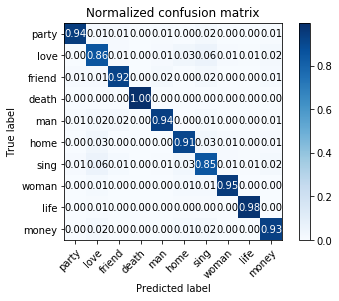

In [35]:
plot_confusion_matrix(y_test, y_pred, classes=[id2word[wid] for wid in y_test.unique()])

In [37]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [38]:
results = pd.DataFrame(model_scores)
results.style.apply(highlight_max, axis=1)

,ETC100,ETC,ETCb,ETCbb,RFC100,RFC,RFCb,RFCbb,STA
accuracy_score,0.934208,0.898817,0.924043,0.89403,0.898294,0.882357,0.895463,0.920343,0.928919
balanced_accuracy_score,0.933459,0.898053,0.923294,0.893231,0.898214,0.882434,0.895417,0.919742,0.928302
f1_score,0.933859,0.89819,0.923446,0.89357,0.898109,0.881963,0.894921,0.920993,0.92927
precision_score,0.934286,0.8987,0.924625,0.894193,0.899044,0.882734,0.896233,0.922285,0.92979
recall_score,0.934208,0.898817,0.924043,0.89403,0.898294,0.882357,0.895463,0.920343,0.928919


## Deep learning model

In [4]:
model_df = pd.read_csv('data/features_balanced.csv')

In [9]:
X = model_df.iloc[:,:-1]
y = to_categorical(model_df.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
len(X_train), len(y_train)

(441804, 441804)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
topwords_input (InputLayer)  (None, 10)                0         
_________________________________________________________________
topwords_embedding (Embeddin (None, 10, 100)           5848900   
_________________________________________________________________
model_flatten (Flatten)      (None, 1000)              0         
_________________________________________________________________
model_relu (Dense)           (None, 927)               927927    
_________________________________________________________________
dropout_1 (Dropout)          (None, 927)               0         
_________________________________________________________________
model_sigmoid (Dense)        (None, 927)               860256    
____________________________________________

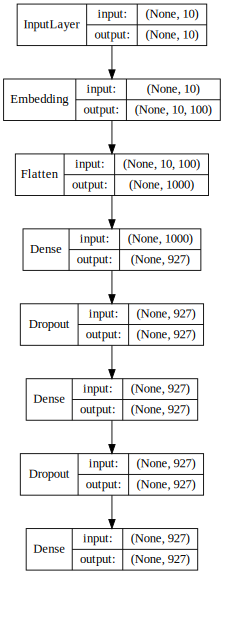

In [10]:
EMBED_SIZE = 100

# Top words
model_input = Input(shape=(10, ), name='topwords_input')
model = Embedding(
    vocab_size, EMBED_SIZE, embeddings_initializer='glorot_uniform',
    name='topwords_embedding')(model_input)

model = Flatten(name='model_flatten')(model)
model = Dense(927, activation='relu', name='model_relu')(model)
model = Dropout(0.20)(model)
model = Dense(927, activation='sigmoid', name='model_sigmoid')(model)
model = Dropout(0.20)(model)
model = Dense(927, activation='softmax', name='model_output')(model)
model = Model([model_input, ], [model,])

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])

print(model.summary())

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=65, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [64]:
fit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=N_ESTIMATORS, verbose=1)

Train on 441804 samples, validate on 147268 samples
Epoch 1/25
441804/441804 [==============================] - 68s 154us/step - loss: 1.1281 - accuracy: 0.6036 - val_loss: 0.7776 - val_accuracy: 0.7299
Epoch 2/25
441804/441804 [==============================] - 68s 153us/step - loss: 0.7570 - accuracy: 0.7357 - val_loss: 0.7291 - val_accuracy: 0.7444
Epoch 3/25
441804/441804 [==============================] - 67s 151us/step - loss: 0.6969 - accuracy: 0.7549 - val_loss: 0.7069 - val_accuracy: 0.7501
Epoch 4/25
441804/441804 [==============================] - 68s 153us/step - loss: 0.6495 - accuracy: 0.7728 - val_loss: 0.6993 - val_accuracy: 0.7542
Epoch 5/25
441804/441804 [==============================] - 68s 154us/step - loss: 0.5963 - accuracy: 0.7927 - val_loss: 0.7267 - val_accuracy: 0.7471
Epoch 6/25
441804/441804 [==============================] - 67s 152us/step - loss: 0.5374 - accuracy: 0.8135 - val_loss: 0.7583 - val_accuracy: 0.7502
Epoch 7/25
441804/441804 [================

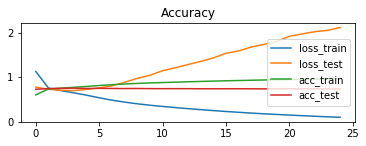

In [65]:
# plot loss during training
plt.subplot(212)
plt.title('Loss')
plt.plot(fit.history['loss'], label='loss_train')
plt.plot(fit.history['val_loss'], label='loss_test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(fit.history['accuracy'], label='acc_train')
plt.plot(fit.history['val_accuracy'], label='acc_test')
plt.legend()
plt.show()

In [66]:
model.save('models/keras_w2v_bal_drop.model')

In [57]:
#model.save('models/keras_w2v.model')
model = load_model('models/keras_w2v_bal_drop.model')

In [55]:
def undo_to_categorical(y, axis=1):
    '''Converts a binary class matrix to a class vector (integers).'''
    return pd.Series(np.argmax(y, axis))

class WrappedModel:
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # do nothing, model should be trained already
        pass
    
    def predict(self, X=None):
        # example: X_test.iloc[:1]
        return undo_to_categorical(model.predict(X))[0]
    
    def transform(self, X):
        y_pred = undo_to_categorical(model.predict_on_batch(X))
        y_pred.index = X.index
        return y_pred

class WrappedModelLoss(WrappedModel):
    def __init__(self, model):
        WrappedModel.__init__(self, model)
    
    def predict(self, X):
        return self.transform(X)

In [67]:
wmodel = WrappedModel(model)
wmodel.fit(X_train, y_train)
y_pred = wmodel.transform(X_test)
scores = {}
for score in (accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score):
    if score in (accuracy_score, balanced_accuracy_score):
        scores[score.__name__] = score(undo_to_categorical(y_test), y_pred)
    else:
        scores[score.__name__] = score(undo_to_categorical(y_test), y_pred, average='weighted')
model_scores['keras_w2v'] = scores
scores

{'accuracy_score': 0.7379810956894912,
 'balanced_accuracy_score': 0.7429635925433734,
 'f1_score': 0.7383429969305704,
 'precision_score': 0.7389902361227391,
 'recall_score': 0.7379810956894912}

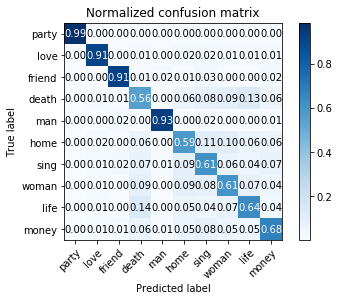

In [68]:
y_test_u = undo_to_categorical(y_test)
plot_confusion_matrix(y_test_u, y_pred, classes=[id2word[wid] for wid in y_test_u.unique()])

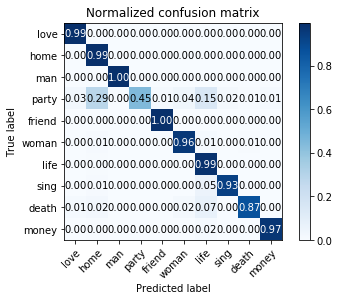

In [280]:
y_test_u = undo_to_categorical(y_test) #unbalanced
plot_confusion_matrix(y_test_u, y_pred, classes=[id2word[wid] for wid in y_test_u.unique()])

In [69]:
wmodel2 = WrappedModelLoss(model)
y_train_u = undo_to_categorical(y_train)
y_train_u.index = X_train.index
y_test_u = undo_to_categorical(y_test)
y_test_u.index = X_test.index
wmodel2.fit(X_train, y_train_u)
#np.vectorize(lambda wid: id2word[wid])(undo_to_categorical(y_train))

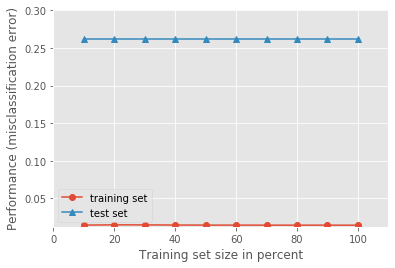

In [70]:
fig = plot_learning_curves(X_train, y_train_u,
                           X_test, y_test_u,
                           wmodel2, print_model=False, style='ggplot')